### Task
Build a machine learning model to predict if an applicant is 'good' or 'bad' client, different from other tasks, the definition of 'good' or 'bad' is not given. You should use some techique, such as vintage analysis to construct you label. Also, unbalance data problem is a big problem in this task.


### About the data set.
there are 2 data sets:
- the first one containing applicant information like gender, annual income, marital states and more. (12 categorical variables,
5 continuous variables, and 1 for applicant ID.)
- the second contains applicants loan history. ( 1 categorical variable, 1 continuousvariable, and 1 variable for applicant ID)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cols= ["client_id", "gender", "car", "property", "cnt_children", "income", "income_cat", "education_level",
        "marital_status", "way_of_living", "birthday", "employment_date", "mobile_phone", "work_phone", "phone",
          "email", "occupation", "family_size"]

client = pd.read_csv(r'Dataset\application_record.csv')
client.columns = cols

In [26]:
credit = pd.read_csv(r'Dataset\credit_record.csv')
credit.columns = ["client_id", "month", "status"]
credit.head()

,client_id,month,status
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [3]:
client.head()

,client_id,gender,car,property,cnt_children,income,income_cat,education_level,marital_status,way_of_living,birthday,employment_date,mobile_phone,work_phone,phone,email,occupation,family_size
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
client.info() # occupation has many NaN values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   client_id        438557 non-null  int64  
 1   gender           438557 non-null  object 
 2   car              438557 non-null  object 
 3   property         438557 non-null  object 
 4   cnt_children     438557 non-null  int64  
 5   income           438557 non-null  float64
 6   income_cat       438557 non-null  object 
 7   education_level  438557 non-null  object 
 8   marital_status   438557 non-null  object 
 9   way_of_living    438557 non-null  object 
 10  birthday         438557 non-null  int64  
 11  employment_date  438557 non-null  int64  
 12  mobile_phone     438557 non-null  int64  
 13  work_phone       438557 non-null  int64  
 14  phone            438557 non-null  int64  
 15  email            438557 non-null  int64  
 16  occupation       304354 non-null  obje

In [7]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   client_id  1048575 non-null  int64 
 1   month      1048575 non-null  int64 
 2   status     1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [8]:
len(set(client['client_id']).intersection(set(credit['client_id']))) # 36457 unique clients shared between both datasets

36457

### Preparing before merge

Credit

In [13]:
credit['status'].unique() # status can be 0, 1, 2, 3, 4, 5
# 0: No DPD, 1: DPD 1-30, 2: DPD 31-60, 3: DPD 61-90, 4: DPD 91-120, 5: DPD >120 
# C: paid off that month X: No loan for the month

array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object)

In [ ]:
# preparinf credit data
credit= credit[credit['status'].notna()]
credit['month_from_today'] = credit['month'].apply(lambda x: x*-1) # convert month to positive value
credit.drop(columns= ['month'], inplace=True) # drop month column
credit['status'] = credit['status'].replace({'C':0, 'X':0}).astype(int) # replace C and X with 0, convert to int
credit['status'].value_counts()

status
0    1034381
1      11090
5       1693
2        868
3        320
4        223
Name: count, dtype: int64

I will focus on the status feature as a measure for acceptability or refusal of an application based on the days past dues. This is how we define the target variable.
- (if there is money that hasn't been paid on a previous card we won't accept his application for a new one)

In [ ]:
credit= credit.copy()
credit['approval']= credit['status'].apply(lambda x: 1 if x== 0 else 0) # 1 if no DPD, 0 otherwise
credit['approval'].value_counts()
# this is the target variable we will use for classification
# looks like we have a class imbalance problem, as there are more approvals than rejections

approval
1    1034381
0      14194
Name: count, dtype: int64

In [ ]:
# occupation has more than 30% NaN values, so we will drop it
client.drop(columns=['occupation'], inplace =True)

In [ ]:
client.drop_duplicates(inplace=True) # remove duplicates (if any)
credit.drop_duplicates(inplace=True) # remove duplicates (if any)

In [ ]:
client.head()

,client_id,gender,car,property,cnt_children,income,income_cat,education_level,marital_status,way_of_living,birthday,employment_date,mobile_phone,work_phone,phone,email,family_size
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0


In [ ]:
df = pd.merge(client, credit, how='left' , on='client_id')


Client

In [ ]:
cat_cols= client.select_dtypes(exclude= 'number').columns
cat_cols
# maybe we can use label encoding for these categorical columns

Index(['gender', 'car', 'property', 'income_cat', 'education_level',
       'marital_status', 'way_of_living'],
      dtype='object')

In [ ]:
num_cols= client.select_dtypes(include='number').columns
num_cols
# maybe we can use standard scaling for these numerical columns

Index(['client_id', 'cnt_children', 'income', 'birthday', 'employment_date',
       'mobile_phone', 'work_phone', 'phone', 'email', 'family_size'],
      dtype='object')

In [35]:
# these are the categorical values
a = client['gender'].value_counts()
b = client['car'].value_counts()
c = client['property'].value_counts()
d = client['income_cat'].value_counts()
e = client['education_level'].value_counts()
f = client['marital_status'].value_counts()
g = client['way_of_living'].value_counts()


print( f'{a} \n  {b} \n  {c}  \n  {d}  \n  {e}  \n  {f}  \n  {g}')

gender
F    294440
M    144117
Name: count, dtype: int64 
  car
N    275459
Y    163098
Name: count, dtype: int64 
  property
Y    304074
N    134483
Name: count, dtype: int64  
  income_cat
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: count, dtype: int64  
  education_level
Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: count, dtype: int64  
  marital_status
Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: count, dtype: int64  
  way_of_living
House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartment         3922
Co-op apartmen

<Axes: xlabel='client_id', ylabel='family_size'>

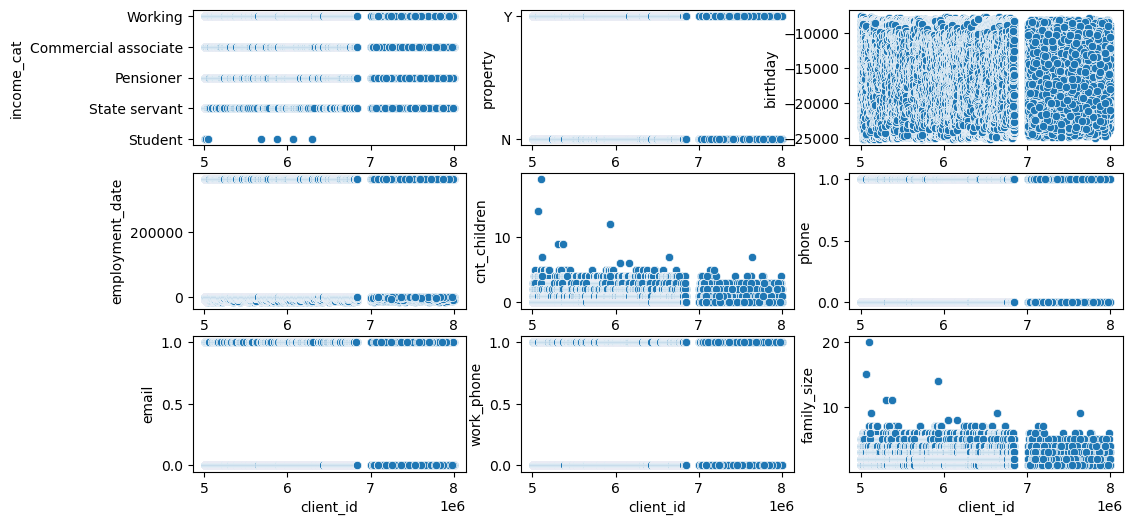

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 6))

sns.scatterplot(x='client_id', y='income_cat', data= client, ax= ax[0][0])
sns.scatterplot(x='client_id', y='property', data= client, ax= ax[0][1])
sns.scatterplot(x='client_id', y='birthday', data= client, ax= ax[0][2])
sns.scatterplot(x='client_id', y='employment_date', data= client, ax= ax[1][0])
sns.scatterplot(x='client_id', y='cnt_children', data= client, ax= ax[1][1])
sns.scatterplot(x='client_id', y='phone', data= client, ax= ax[1][2])
sns.scatterplot(x='client_id', y='email', data= client, ax= ax[2][0])
sns.scatterplot(x='client_id', y='work_phone', data= client, ax= ax[2][1])
sns.scatterplot(x='client_id', y='family_size', data= client, ax= ax[2][2])

# to get rid of the outliers, I need to turn the categorical columns into numerical values 


these variables have  outliers, so maybe remove them then train the model again
- family_size
- cnt_children
- income_cat 


### Initial Preprocessing

In [42]:
# Convert categorical variables to numerical using Label Encoding

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for c in client.columns:
    if client[c].dtype== 'object':
        client[c] = le.fit_transform(client[c].astype(str))
        label_encoder = le



In [43]:
client= client[(client['income_cat'] < client['income_cat'].quantile(.999)) & (client['income_cat'] > client['income_cat'].quantile(.001))]
client= client[(client['family_size'] < client['family_size'].quantile(.999)) & (client['family_size'] > client['family_size'].quantile(.001))]
client= client[(client['cnt_children'] < client['cnt_children'].quantile(.999)) & (client['cnt_children'] > client['cnt_children'].quantile(.001))]

<Axes: xlabel='client_id', ylabel='family_size'>

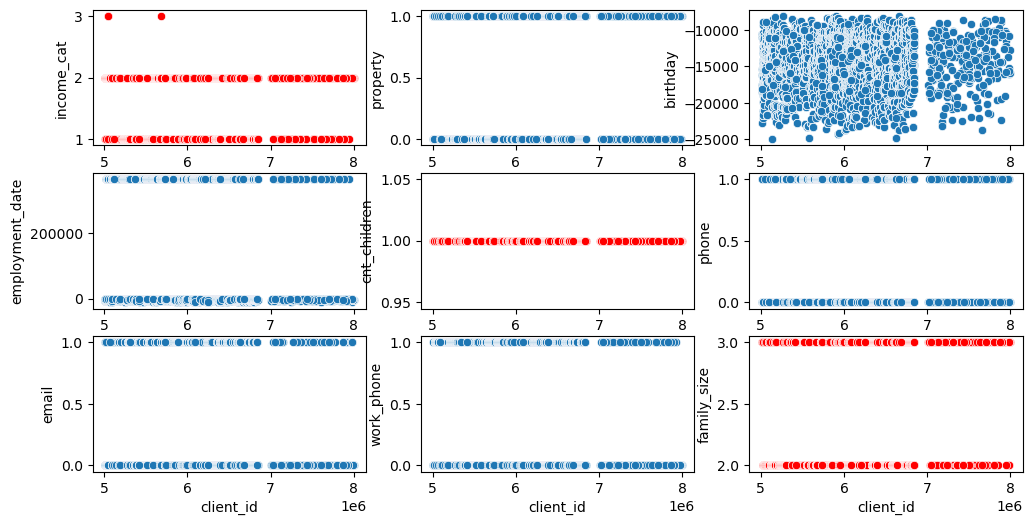

In [44]:
# after removing outliers, we can plot the data again to see if the distribution is better
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 6))

sns.scatterplot(x='client_id', y='income_cat', data= client, ax= ax[0][0], color='red') # color red to see if the distribution is better after removing outliers
sns.scatterplot(x='client_id', y='property', data= client, ax= ax[0][1])
sns.scatterplot(x='client_id', y='birthday', data= client, ax= ax[0][2])
sns.scatterplot(x='client_id', y='employment_date', data= client, ax= ax[1][0])
sns.scatterplot(x='client_id', y='cnt_children', data= client, ax= ax[1][1],color='red')
sns.scatterplot(x='client_id', y='phone', data= client, ax= ax[1][2])
sns.scatterplot(x='client_id', y='email', data= client, ax= ax[2][0])
sns.scatterplot(x='client_id', y='work_phone', data= client, ax= ax[2][1])
sns.scatterplot(x='client_id', y='family_size', data= client, ax= ax[2][2], color='red') 
# better after removing outliers?


### Preprocessing

Joining the two dataframes

In [47]:
df= pd.merge(left=client, right=credit, how= 'inner', on= 'client_id')
df.head()

,client_id,gender,car,property,cnt_children,income,income_cat,education_level,marital_status,way_of_living,birthday,employment_date,mobile_phone,work_phone,phone,email,family_size,status,month_from_today,approval
0,5008868,0,0,1,1,211500.0,2,4,0,1,-16212,-7099,1,0,0,0,3.0,0,0,1
1,5008868,0,0,1,1,211500.0,2,4,0,1,-16212,-7099,1,0,0,0,3.0,0,1,1
2,5008868,0,0,1,1,211500.0,2,4,0,1,-16212,-7099,1,0,0,0,3.0,0,2,1
3,5008868,0,0,1,1,211500.0,2,4,0,1,-16212,-7099,1,0,0,0,3.0,0,3,1
4,5008868,0,0,1,1,211500.0,2,4,0,1,-16212,-7099,1,0,0,0,3.0,0,4,1


In [48]:
df.shape

(19115, 20)

### Train, Valid, Test Sets

In [ ]:
#train, valid, test = np.split(df_w_class.sample(frac=1),[int(.6*len(df_w_class)), int(.8*len(df_w_class))])

In [49]:

X= df.drop(columns=['client_id', 'status', 'approval']) # features to avoid data leakage (do I drop client_id?)
y= df['approval'] # target variable

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Sampling and Scaling

In [50]:
print(X_train.shape, y_train.shape) # 17 features in the X and 1 target variable in y

(15292, 17) (15292,)


In [51]:
# the train set is unbalanced, we will use oversampling to balance it
print(len(y_train[y_train==1]))
print(len(y_train[y_train==0]))   

15050
242


In [52]:
from imblearn.over_sampling import RandomOverSampler

ros= RandomOverSampler(random_state=42) # only oversampling the training set
X_train, y_train = ros.fit_resample(X_train, y_train)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # standardize the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# or from imblearn.pipeline import Pipeline
#from sklearn.linear_model import LogisticRegression
#
#pipeline = Pipeline(steps=[
#    ('oversample', RandomOverSampler()),
#    ('scaler', StandardScaler()),
#    ('model', LogisticRegression())
#])
#
#pipeline.fit(X_train, y_train)


In [53]:
# now the train set is balanced
print(len(y_train[y_train==1]))
print(len(y_train[y_train==0]))   

15050
15050


In [ ]:
print(X_train[:5])  # scaled features

[[-0.70472632  1.24680848  0.71835223 -0.57231186 -0.26178146 -0.22626335
   0.67822501 -0.37069096 -0.28927031 -1.45565055 -0.53435745  0.
  -0.54633177 -0.65507252 -0.32041199 -0.23041825  0.47903838]
 [ 1.41899056 -0.8020478   0.71835223 -0.57231186  1.231611    0.92565325
  -1.55224551  1.77898638 -0.28927031  1.28255091 -0.44528416  0.
  -0.54633177 -0.65507252 -0.32041199 -1.33006417  1.38815665]
 [-0.70472632 -0.8020478  -1.39207475 -0.57231186 -0.08608823 -0.80222165
  -1.55224551  1.77898638 -0.28927031 -1.23437928  2.25652757  0.
  -0.54633177  1.52654855 -0.32041199 -1.33006417 -0.29021555]
 [-0.70472632 -0.8020478  -1.39207475  0.76233127  3.42777637  0.92565325
   0.67822501  0.70414771 -0.28927031 -0.06776494 -0.43766272  0.
   1.83038961 -0.65507252 -0.32041199 -0.23041825  0.6888349 ]
 [-0.70472632  1.24680848  0.71835223  2.09697441  0.35314485 -1.37817995
  -1.55224551 -0.37069096 -0.28927031  0.49553756 -0.44923792  0.
  -0.54633177 -0.65507252 -0.32041199  1.9688735

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [55]:
# Define and train various classification models to predict loan approval and choose the best one

classification_models = {
    "Logistic Regression" : LogisticRegression(),
    "K-Nearest Neighbors" : KNeighborsClassifier(),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier()
}

for name, model in classification_models.items():
    model.fit(X_train, y_train)
    print(f"{name} model trained.")
    print(classification_report(y_test, model.predict(X_test)))



Logistic Regression model trained.
              precision    recall  f1-score   support

           0       0.03      0.69      0.06        61
           1       0.99      0.66      0.79      3762

    accuracy                           0.66      3823
   macro avg       0.51      0.67      0.43      3823
weighted avg       0.98      0.66      0.78      3823

K-Nearest Neighbors model trained.
              precision    recall  f1-score   support

           0       0.23      0.43      0.30        61
           1       0.99      0.98      0.98      3762

    accuracy                           0.97      3823
   macro avg       0.61      0.70      0.64      3823
weighted avg       0.98      0.97      0.97      3823

Decision Tree model trained.
              precision    recall  f1-score   support

           0       0.17      0.33      0.22        61
           1       0.99      0.97      0.98      3762

    accuracy                           0.96      3823
   macro avg       0.58      

In [56]:
svc_model= SVC().fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)

print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.07      0.79      0.13        61
           1       1.00      0.84      0.91      3762

    accuracy                           0.84      3823
   macro avg       0.53      0.81      0.52      3823
weighted avg       0.98      0.84      0.90      3823



In [57]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.15      0.46      0.22        61
           1       0.99      0.96      0.97      3762

    accuracy                           0.95      3823
   macro avg       0.57      0.71      0.60      3823
weighted avg       0.98      0.95      0.96      3823



d:\Programing\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:05:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The highest model is K-Nearest Neighbors with accuracy of 97% which is great compared to
- SVC with 84%
- Logistic Regression with 66% (the worst performer)
- Decision Tree with 96%
- Random Forest with 96%
- XGBClassifier with 95%